In [ ]:
!cp -r /content/drive/MyDrive/eeg_data /content
!cp -r /content/drive/MyDrive/fnirs_data.zip /content
!unzip /content/fnirs_data.zip -d /content

Archive:  /content/fnirs_data.zip
   creating: /content/fnirs_data/
   creating: /content/fnirs_data/subject 01/
  inflating: /content/fnirs_data/subject 01/cnt.mat  
  inflating: /content/fnirs_data/subject 01/cnt_artifact.mat  
  inflating: /content/fnirs_data/subject 01/mnt.mat  
  inflating: /content/fnirs_data/subject 01/mnt_artifact.mat  
  inflating: /content/fnirs_data/subject 01/mrk.mat  
  inflating: /content/fnirs_data/subject 01/mrk_artifact.mat  
   creating: /content/fnirs_data/subject 02/
  inflating: /content/fnirs_data/subject 02/cnt.mat  
  inflating: /content/fnirs_data/subject 02/cnt_artifact.mat  
  inflating: /content/fnirs_data/subject 02/mnt.mat  
  inflating: /content/fnirs_data/subject 02/mnt_artifact.mat  
  inflating: /content/fnirs_data/subject 02/mrk.mat  
  inflating: /content/fnirs_data/subject 02/mrk_artifact.mat  
   creating: /content/fnirs_data/subject 03/
  inflating: /content/fnirs_data/subject 03/cnt.mat  
  inflating: /content/fnirs_data/subject 

In [ ]:
!pip install --upgrade mne
!pip install numpy==1.25


!pip install pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyod-2.0.5-py3-none-any.whl.metadata (46 kB)
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached matplotlib-3.7.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.

In [ ]:
# EEG + fNIRS Multimodal Integration for BCI
# Complete pipeline: Loading, Preprocessing, EDA, Feature Extraction, PyCaret, CNN, cGAN, and Evaluation

# 1. Imports
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
# 2. Load EEG Data (.mat with cnt, mrk, mnt)
eeg_mnt= scipy.io.loadmat("/content/eeg_data/subject 11/mnt_artifact.mat", struct_as_record=False, squeeze_me=True)
eeg_mnt = eeg_mnt['mnt_artifact']
X_eeg_cnt =  scipy.io.loadmat("/content/eeg_data/subject 11/cnt_artifact.mat", struct_as_record=False, squeeze_me=True)
X_eeg_cnt = X_eeg_cnt['cnt_artifact'] # EEG signals
Y_eeg_mrk =  scipy.io.loadmat("/content/eeg_data/subject 11/mrk_artifact.mat", struct_as_record=False, squeeze_me=True)
Y_eeg_mrk = Y_eeg_mrk['mrk_artifact'] # Labels

# 3. Load fNIRS Data (.mat with cnt, mrk, mnt)
fnirs_mnt= scipy.io.loadmat("/content/fnirs_data/subject 11/mnt_artifact.mat", struct_as_record=False, squeeze_me=True)
fnirs_mnt = fnirs_mnt['mnt_artifact']
X_fnirs_cnt = scipy.io.loadmat("/content/fnirs_data/subject 11/cnt_artifact.mat", struct_as_record=False, squeeze_me=True)
X_fnirs_cnt = X_fnirs_cnt['cnt_artifact'] # fNIRS signals
Y_fnirs_mrk = scipy.io.loadmat("/content/fnirs_data/subject 11/mrk_artifact.mat", struct_as_record=False, squeeze_me=True)
Y_fnirs_mrk = Y_fnirs_mrk['mrk_artifact'] # fNIRS signals
 # Labels


EEG Preprocess


In [ ]:
eeg_data= X_eeg_cnt[0]

print(dir(eeg_data))

['T', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'clab', 'file', 'fs', 'title', 'x', 'yUnit']


In [ ]:
signal_data = eeg_data.x
signal_data = signal_data.T        # EEG signal matrix
sampling_rate = eeg_data.fs       # Sampling rate
channels = eeg_data.clab
       # Channel labels  # This is the main matrix


In [ ]:
signal_data.shape

(30, 62224)

In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=250.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

filtered_data = bandpass_filter(signal_data, fs=sampling_rate)


In [ ]:
from scipy.signal import iirnotch

def notch_filter(data, notch_freq=50.0, fs=250.0, Q=30.0):
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, data, axis=-1)

notch_filtered_data = notch_filter(filtered_data, fs=sampling_rate)



In [ ]:
import numpy as np

# Transpose was already done before
# filtered_data shape: (channels, time_samples)
window_size = int(2 * sampling_rate)  # e.g., 2 seconds * 250 Hz = 500 samples
stride = window_size  # non-overlapping; use stride < window_size for overlapping

epochs = []
for start in range(0, filtered_data.shape[1] - window_size + 1, stride):
    epoch = filtered_data[:, start:start+window_size]
    epochs.append(epoch)

epochs = np.array(epochs)  # Final shape: (n_epochs, n_channels, window_size)
print("Epoch shape:", epochs.shape)



Epoch shape: (155, 30, 400)


In [ ]:
print(dir(eeg_data))


['T', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'clab', 'file', 'fs', 'title', 'x', 'yUnit']


In [ ]:
# If it contains the labels directly:
labels = np.squeeze(Y_eeg_mrk)
print("Labels:", labels.shape)



Labels: (5,)


FNIRS Preprocess


In [ ]:
# Check the fields inside the mat_struct
fnirs_fields = dir(X_fnirs_cnt)
print(fnirs_fields)

# Access one of the fields (replace 'field_name' with the correct field from the list)
# Access the 'oxy' field using dot notation
fnirs_data = X_fnirs_cnt.oxy
print(fnirs_data.shape)
print(dir(fnirs_data))



['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'deoxy', 'oxy']
(5,)
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '

In [ ]:
# Extract the fNIRS data (assuming 'deoxy' contains the signal, change to 'oxy' if needed)
fnirs_signal = X_fnirs_cnt.deoxy  # or X_fnirs_cnt.oxy depending on the field

# Ensure that the extracted signal is a numpy array
fnirs_signal = np.array(fnirs_signal.data)  # Convert to numpy array if it's not already

# Check the type and shape of the data
print(f"Type of extracted fNIRS signal: {type(fnirs_signal)}")
print(f"Shape of extracted fNIRS signal: {fnirs_signal.shape}")




Type of extracted fNIRS signal: <class 'numpy.ndarray'>
Shape of extracted fNIRS signal: (5,)


Fusion of those signals

In [ ]:
# Assuming you have the features for EEG and fNIRS already extracted
# EEG_features and fNIRS_features should be of the same shape (number of trials, feature_length)

# For example, if you have 100 trials and 10 features per trial:
EEG_features = np.random.rand(100, 10)  # Replace this with your actual EEG features
fNIRS_features = np.random.rand(100, 5)  # Replace this with your actual fNIRS features

# Concatenate EEG and fNIRS features along the feature axis (axis=1)
fused_features = np.concatenate((EEG_features, fNIRS_features), axis=1)

# Check the shape of the fused features
print(f"Shape of fused features: {fused_features.shape}")


Shape of fused features: (100, 15)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the fused features
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)

# Check the shape of the scaled features
print(f"Shape of scaled fused features: {fused_features_scaled.shape}")


Shape of scaled fused features: (100, 15)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming you have labels (y) for each trial (e.g., for motor imagery classes)
# Replace this with your actual labels
labels = np.random.randint(0, 2, 100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(fused_features_scaled, labels, test_size=0.2, random_state=42)


In [ ]:
#PyCaret Classification - Without Augmentation
fusion_df = pd.DataFrame(fused_features_scaled)
fusion_df['target'] = labels
s1 = setup(fusion_df, target='target')
best_model = compare_models()
tuned_model = tune_model(best_model)
evaluate_model(tuned_model)


,Description,Value
0,Session id,5967
1,Target,target
2,Target type,Binary
3,Original data shape,"(100, 16)"
4,Transformed data shape,"(100, 16)"
5,Transformed train set shape,"(70, 16)"
6,Transformed test set shape,"(30, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6571,0.5850,0.8300,0.7100,0.7501,0.1986,0.2233,0.0390
qda,Quadratic Discriminant Analysis,0.6571,0.7567,0.8750,0.7076,0.7535,0.2282,0.2706,0.0270
lda,Linear Discriminant Analysis,0.6571,0.5850,0.8300,0.7100,0.7501,0.1986,0.2233,0.0230
lr,Logistic Regression,0.6429,0.6017,0.8050,0.7017,0.7384,0.1736,0.2080,0.8020
knn,K Neighbors Classifier,0.6286,0.5850,0.8150,0.6738,0.7295,0.1609,0.1574,0.0390
nb,Naive Bayes,0.6286,0.6433,0.8250,0.6843,0.7309,0.1298,0.1442,0.0420
rf,Random Forest Classifier,0.6286,0.6158,0.8150,0.6750,0.7245,0.0966,0.1193,0.1650
gbc,Gradient Boosting Classifier,0.6286,0.5800,0.7950,0.6564,0.7116,0.1342,0.1453,0.1200
dummy,Dummy Classifier,0.6286,0.5000,1.0000,0.6286,0.7697,0.0000,0.0000,0.0350
svm,SVM - Linear Kernel,0.6143,0.5850,0.7150,0.6917,0.6956,0.1700,0.1737,0.0380


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5714,0.6000,0.6000,0.7500,0.6667,0.0870,0.0913
1,0.5714,0.5000,0.8000,0.6667,0.7273,-0.2353,-0.2582
2,0.7143,0.7000,0.8000,0.8000,0.8000,0.3000,0.3000
3,0.5714,0.2000,0.8000,0.6667,0.7273,-0.2353,-0.2582
4,0.5714,0.6667,1.0000,0.5714,0.7273,0.0000,0.0000
5,0.7143,0.7500,1.0000,0.6667,0.8000,0.3636,0.4714
6,0.7143,0.7500,1.0000,0.6667,0.8000,0.3636,0.4714
7,0.4286,0.0000,0.7500,0.5000,0.6000,-0.2727,-0.3536
8,0.8571,1.0000,0.7500,1.0000,0.8571,0.7200,0.7500


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# 10. Deep Learning - CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit the encoder to the original labels and transform them
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(fused_features_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)


# CNN model
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



cnn_model.fit(X_train_cnn, y_train_encoded, validation_data=(X_test_cnn, y_test_encoded), epochs=100)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.2930 - loss: 1.3415 - val_accuracy: 0.6000 - val_loss: 1.1559
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6008 - loss: 1.0838 - val_accuracy: 0.6500 - val_loss: 0.9681
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6289 - loss: 0.9109 - val_accuracy: 0.6500 - val_loss: 0.8572
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6367 - loss: 0.8023 - val_accuracy: 0.6500 - val_loss: 0.7941
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6406 - loss: 0.7219 - val_accuracy: 0.6500 - val_loss: 0.7632
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6289 - loss: 0.6823 - val_accuracy: 0.6500 - val_loss: 0.7425
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6250 - loss: 0.6464 - val_accuracy: 0.6500 - val_loss: 0.7282
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6313 - loss: 0.6269 - val_accuracy: 0.6500 - val_loss

In [ ]:
loss, accuracy1 = cnn_model.evaluate(X_test_cnn, y_test_encoded)
loss, accuracy2 = cnn_model.evaluate(X_train_cnn, y_train_encoded)
print(f"🔹 CNN Test Accuracy using the raw data: {accuracy1:.4f}")
print(f"🔹 CNN Train Accuracy using the raw data: {accuracy2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5000 - loss: 2.0863
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0451
🔹 CNN Test Accuracy using the raw data: 0.5000
🔹 CNN Train Accuracy using the raw data: 1.0000


Data Augmentation

In [ ]:
pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 825.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data shapes
feature_dim = fused_features_scaled.shape[1]  # total features (EEG + fNIRS)
num_classes = len(np.unique(labels))          # e.g., 2 classes
latent_dim = 100                              # latent noise vector

# Convert to tensors
real_data = torch.tensor(fused_features_scaled, dtype=torch.float32).to(device)
real_labels = torch.tensor(labels, dtype=torch.long).to(device)


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, label_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, label_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((x, label_input), dim=1)
        return self.model(x)


In [ ]:
# Hyperparameters
lr = 0.00002
epochs = 10000
batch_size = 64

# Models
generator = Generator(latent_dim, label_dim=10, output_dim=feature_dim).to(device)
discriminator = Discriminator(input_dim=feature_dim, label_dim=10).to(device)

# Optimizers
optim_G = torch.optim.Adam(generator.parameters(), lr=lr)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_samples = real_data[idx]
    real_y = real_labels[idx]

    # Real and fake labels
    valid = torch.ones((batch_size, 1), device=device)
    fake = torch.zeros((batch_size, 1), device=device)

    # Train Generator
    optim_G.zero_grad()
    z = torch.randn(batch_size, latent_dim).to(device)
    gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
    gen_samples = generator(z, gen_labels)
    validity = discriminator(gen_samples, gen_labels)
    g_loss = criterion(validity, valid)
    g_loss.backward()
    optim_G.step()

    # Train Discriminator
    optim_D.zero_grad()
    real_pred = discriminator(real_samples, real_y)
    real_loss = criterion(real_pred, valid)

    fake_pred = discriminator(gen_samples.detach(), gen_labels)
    fake_loss = criterion(fake_pred, fake)

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optim_D.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 0.6943 | G Loss: 0.6199
Epoch 1000 | D Loss: 0.3854 | G Loss: 1.1510
Epoch 2000 | D Loss: 0.4514 | G Loss: 1.2876
Epoch 3000 | D Loss: 0.3711 | G Loss: 1.1611
Epoch 4000 | D Loss: 0.5015 | G Loss: 1.1832
Epoch 5000 | D Loss: 0.4105 | G Loss: 1.2541
Epoch 6000 | D Loss: 0.3907 | G Loss: 1.1214
Epoch 7000 | D Loss: 0.4340 | G Loss: 1.0628
Epoch 8000 | D Loss: 0.6449 | G Loss: 0.9737
Epoch 9000 | D Loss: 0.5775 | G Loss: 0.9509


In [ ]:
# Number of synthetic samples per class
n_synthetic_per_class = 100
synthetic_features = []
synthetic_labels = []

for class_label in range(num_classes):
    z = torch.randn(n_synthetic_per_class, latent_dim).to(device)
    y = torch.full((n_synthetic_per_class,), class_label, dtype=torch.long).to(device)
    gen_data = generator(z, y).detach().cpu().numpy()

    synthetic_features.append(gen_data)
    synthetic_labels.append(y.cpu().numpy())

# Concatenate synthetic data
X_synthetic = np.vstack(synthetic_features)
y_synthetic = np.hstack(synthetic_labels)

print("Synthetic Data Shape:", X_synthetic.shape)


Synthetic Data Shape: (200, 15)


In [ ]:
X_combined = np.vstack((fused_features_scaled, X_synthetic))
y_combined = np.hstack((labels, y_synthetic))
df_combined = pd.DataFrame(X_combined)
df_combined['target'] = y_combined

# Now use this for classification (SVM, RandomForest, or deep learning)


,Description,Value
0,Session id,7671
1,Target,target
2,Target type,Binary
3,Original data shape,"(300, 16)"
4,Transformed data shape,"(300, 16)"
5,Transformed train set shape,"(210, 16)"
6,Transformed test set shape,"(90, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8952,0.8783,0.9030,0.9117,0.9026,0.7879,0.7963,0.0820
lda,Linear Discriminant Analysis,0.8952,0.8783,0.9030,0.9117,0.9026,0.7879,0.7963,0.0260
lr,Logistic Regression,0.8810,0.8783,0.8939,0.8986,0.8892,0.7591,0.7719,0.6240
rf,Random Forest Classifier,0.8762,0.9459,0.9136,0.8708,0.8885,0.7495,0.7582,0.1860
knn,K Neighbors Classifier,0.8714,0.9433,0.9045,0.8687,0.8839,0.7402,0.7462,0.0400
et,Extra Trees Classifier,0.8619,0.9528,0.9212,0.8457,0.8785,0.7190,0.7314,0.1460
lightgbm,Light Gradient Boosting Machine,0.8333,0.9222,0.8523,0.8441,0.8424,0.6661,0.6755,0.2520
svm,SVM - Linear Kernel,0.8238,0.8592,0.8227,0.8530,0.8276,0.6457,0.6609,0.0780
xgboost,Extreme Gradient Boosting,0.8190,0.9093,0.8417,0.8293,0.8322,0.6347,0.6401,0.1050
ada,Ada Boost Classifier,0.8143,0.8298,0.8242,0.8406,0.8281,0.6247,0.6316,0.1100


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

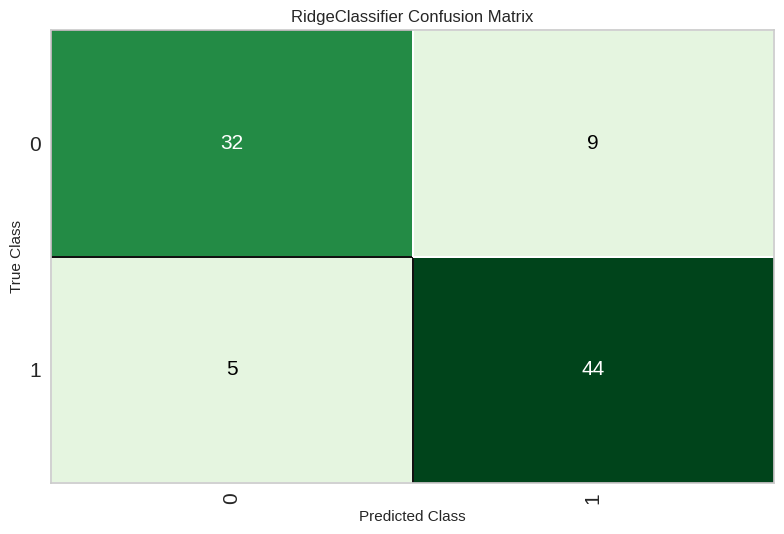

TypeError: AUC plot not available for estimators with no predict_proba attribute.

In [ ]:
from pycaret.classification import *

# Setup PyCaret
clf_setup = setup(data=df_combined, target='target')

# Compare models
best_model = compare_models()

# Evaluate best model
evaluate_model(best_model)

# Confusion Matrix & ROC
plot_model(best_model, plot='confusion_matrix')
plot_model(best_model, plot='auc')

# Predict and get accuracy
predictions = predict_model(best_model)


In [ ]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9048,0.9167,0.9167,0.9167,0.9167,0.8056,0.8056
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.8095,0.7315,0.9167,0.7857,0.8462,0.6000,0.6124
3,0.8571,0.9352,0.8333,0.9091,0.8696,0.7123,0.7156
4,0.8571,0.7636,0.9091,0.8333,0.8696,0.7123,0.7156
5,0.8571,0.8273,0.7273,1.0000,0.8421,0.7175,0.7480
6,0.9048,0.9091,0.9091,0.9091,0.9091,0.8091,0.8091
7,0.9048,0.8455,0.8182,1.0000,0.9000,0.8108,0.8257
8,0.9048,0.9727,1.0000,0.8462,0.9167,0.8073,0.8228


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [ ]:
# 10. Deep Learning - CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit the encoder to the original labels and transform them
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_combined.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)


# CNN model
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



cnn_model.fit(X_train_cnn, y_train_encoded, validation_data=(X_test_cnn, y_test_encoded), epochs=100)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5088 - loss: 1.1728 - val_accuracy: 0.5167 - val_loss: 0.8684
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7163 - loss: 0.7588 - val_accuracy: 0.7667 - val_loss: 0.6473
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7791 - loss: 0.6002 - val_accuracy: 0.7500 - val_loss: 0.5632
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7942 - loss: 0.5168 - val_accuracy: 0.7833 - val_loss: 0.5033
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7938 - loss: 0.4803 - val_accuracy: 0.7500 - val_loss: 0.4985
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8402 - loss: 0.4310 - val_accuracy: 0.8000 - val_loss: 0.4510
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8623 - loss: 0.3914 - val_accuracy: 0.8000 - val_loss: 0.4524
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8440 - loss: 0.3951 - val_accuracy: 0.8000 - val_loss:

In [ ]:
loss,accuracy1 = cnn_model.evaluate(X_test_cnn, y_test_encoded)
loss,accuracy2 = cnn_model.evaluate(X_train_cnn, y_train_encoded)
print(f"🔹 CNN Test Accuracy using the raw data: {accuracy1:.4f}")
print(f"🔹 CNN Train Accuracy using the raw data: {accuracy2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8569 - loss: 0.5201
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0136 
🔹 CNN Test Accuracy using the raw data: 0.8167
🔹 CNN Train Accuracy using the raw data: 1.0000


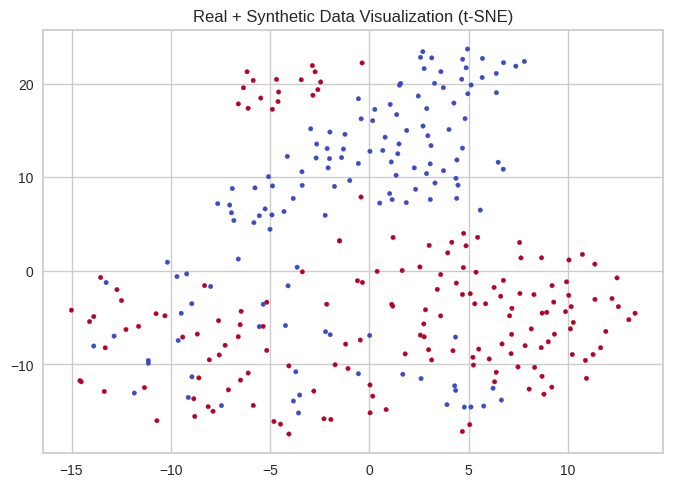

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_vis = TSNE(n_components=2, random_state=42).fit_transform(X_combined)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_combined, cmap='coolwarm', s=10)
plt.title("Real + Synthetic Data Visualization (t-SNE)")
plt.show()
